In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.multioutput import MultiOutputRegressor
from sklego.preprocessing import RepeatingBasisFunction
from flaml.automl import AutoML
from flaml.automl.data import get_output_from_log
import re   
import pickle

sns.set_theme(rc={'figure.figsize': (15 / 1.3, 10.5 / 1.3),
                  "lines.linewidth": 2.5}, font_scale=1)
sns.set_style('whitegrid')
sns.set_palette('husl')

In [2]:
df = pd.read_csv(r'data/database.csv')
df.shape

(2795, 48)

## EDA

In [3]:
df.drop_duplicates(inplace=True)
df.shape

(2795, 48)

In [7]:
df.sample(5)

Report Number  Supplemental Number  Accident Year  Accident Date/Time  \
2012       20150128                20315           2015   3/10/2015 9:00 PM   
708        20120045                18069           2012   1/17/2012 2:08 PM   
2033       20160352                21798           2015   3/24/2015 8:30 AM   
1800       20140363                19995           2014  9/14/2014 12:10 PM   
2579       20160206                21482           2016   6/20/2016 6:00 AM   

      Operator ID                        Operator Name  \
2012        31618    ENTERPRISE PRODUCTS OPERATING LLC   
708         26041  KINDER MORGAN LIQUID TERMINALS, LLC   
2033        32537             WYOMING PIPELINE COMPANY   
1800        26134     EXXONMOBIL OIL CORP - WEST COAST   
2579        39307                 VITOL MIDSTREAM, LLC   

          Pipeline/Facility Name Pipeline Location Pipeline Type  \
2012  NORTH PORT ARTHUR TERMINAL           ONSHORE   ABOVEGROUND   
708                          NaN           ONSHORE   ABOVEGROUND   
2033    WYOMING PIPELINE COMPANY           ONSHORE   ABOVEGROUND   
1800       M-55/BELRIDGE STATION           ONSHORE   ABOVEGROUND   
2579             MIDKIFF STATION           ONSHORE   ABOVEGROUND   

                                            Liquid Type  ... Other Fatalities  \
2012  REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...  ...              NaN   
708   REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...  ...              NaN   
2033                                          CRUDE OIL  ...              NaN   
1800                                          CRUDE OIL  ...              NaN   
2579                                          CRUDE OIL  ...              NaN   

     Public Fatalities All Fatalities Property Damage Costs  \
2012               NaN            NaN                9928.0   
708                NaN            NaN               35000.0   
2033               NaN            NaN                 300.0   
1800               NaN            NaN                 500.0   
2579               NaN            NaN                   0.0   

     Lost Commodity Costs  Public/Private Property Damage Costs  \
2012                 54.0                                   0.0   
708                   5.0                                   0.0   
2033                 25.0                                   0.0   
1800                 10.0                                   0.0   
2579                200.0                                   0.0   

      Emergency Response Costs Environmental Remediation Costs Other Costs  \
2012                       0.0                             0.0         0.0   
708                        0.0                             0.0         0.0   
2033                     200.0                           200.0         0.0   
1800                    2500.0                             0.0         0.0   
2579                     300.0                          5000.0         0.0   

      All Costs  
2012       9982  
708       35005  
2033        725  
1800       3010  
2579       5500  

[5 rows x 48 columns]

In [5]:
df.describe()

Report Number  Supplemental Number  Accident Year   Operator ID  \
count   2.795000e+03          2795.000000    2795.000000   2795.000000   
mean    2.013293e+07         19433.319499    2013.187835  21388.476565   
std     1.982098e+04          1724.815370       1.972102  12430.973428   
min     2.010000e+07         15072.000000    2010.000000    300.000000   
25%     2.012004e+07         17978.500000    2012.000000  11169.000000   
50%     2.013037e+07         19502.000000    2013.000000  26041.000000   
75%     2.015023e+07         20996.500000    2015.000000  31618.000000   
max     2.017003e+07         22049.000000    2017.000000  99043.000000   

       Accident Latitude  Accident Longitude  Unintentional Release (Barrels)  \
count        2795.000000         2795.000000                      2795.000000   
mean           35.781608          -95.682691                       207.245843   
std             5.652599           12.328430                      1368.667813   
min            18.448010         -158.099930                         0.000000   
25%            30.909375         -100.587636                         0.480000   
50%            34.925440          -95.488870                         2.000000   
75%            40.264062          -91.089463                        20.000000   
max            70.261265          104.263399                     30565.000000   

       Intentional Release (Barrels)  Liquid Recovery (Barrels)  \
count                    1209.000000                2795.000000   
mean                      238.533623                  75.051792   
std                      2781.771453                 546.188247   
min                         0.000000                   0.000000   
25%                         0.000000                   0.000000   
50%                         0.000000                   0.740000   
75%                         0.000000                   8.000000   
max                     70191.000000               18245.000000   

       Net Loss (Barrels)  ...  Other Fatalities  Public Fatalities  \
count         2795.000000  ...          8.000000           8.000000   
mean           132.194050  ...          0.125000           0.625000   
std           1185.019252  ...          0.353553           0.744024   
min              0.000000  ...          0.000000           0.000000   
25%              0.000000  ...          0.000000           0.000000   
50%              0.000000  ...          0.000000           0.500000   
75%              2.000000  ...          0.000000           1.000000   
max          30565.000000  ...          1.000000           2.000000   

       All Fatalities  Property Damage Costs  Lost Commodity Costs  \
count         8.00000           2.788000e+03          2.791000e+03   
mean          1.25000           1.122963e+05          9.805299e+03   
std           0.46291           8.709947e+05          6.384075e+04   
min           1.00000           0.000000e+00          0.000000e+00   
25%           1.00000           1.000000e+02          2.000000e+01   
50%           1.00000           3.000000e+03          1.000000e+02   
75%           1.25000           2.500000e+04          7.000000e+02   
max           2.00000           2.700000e+07          1.417839e+06   

       Public/Private Property Damage Costs  Emergency Response Costs  \
count                          2.785000e+03              2.789000e+03   
mean                           2.512195e+04              2.918911e+05   
std                            5.243581e+05              4.617076e+06   
min                            0.000000e+00              0.000000e+00   
25%                            0.000000e+00              0.000000e+00   
50%                            0.000000e+00              2.520000e+03   
75%                            0.000000e+00              1.550000e+04   
max                            2.300000e+07              1.770000e+08   

       Environmental Remediation Costs   Other Costs     All Costs  
count   

In [5]:
df.describe(exclude='number')

Accident Date/Time                  Operator Name  \
count                  2795                           2795   
unique                 2777                            229   
top     12/10/2011 10:50 AM  ENTERPRISE CRUDE PIPELINE LLC   
freq                      2                            195   

          Pipeline/Facility Name Pipeline Location Pipeline Type Liquid Type  \
count                       2674              2795          2777        2795   
unique                      1977                 2             4           5   
top     WYOMING PIPELINE COMPANY           ONSHORE   ABOVEGROUND   CRUDE OIL   
freq                          20              2777          1475        1398   

                              Liquid Subtype Liquid Name Accident City  \
count                                   1349         222          2480   
unique                                     8          69          1027   
top     DIESEL, FUEL OIL, KEROSENE, JET FUEL     PROPANE       CUSHING   
freq                                     408          26            78   

       Accident County Accident State               Cause Category  \
count             2720           2783                         2795   
unique             678             46                            7   
top             HARRIS             TX  MATERIAL/WELD/EQUIP FAILURE   
freq               167           1004                         1435   

       Cause Subcategory Liquid Ignition Liquid Explosion Pipeline Shutdown  \
count               2795            2795             2795              2583   
unique                38               2                2                 2   
top             INTERNAL              NO               NO               YES   
freq                 362            2700             2780              1395   

       Shutdown Date/Time Restart Date/Time  
count                1390              1341  
unique               1385              1334  
top       12/28/2013 9:30   10/30/2013 8:00  
freq                    2                 2

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 48 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Report Number                         2795 non-null   int64  
 1   Supplemental Number                   2795 non-null   int64  
 2   Accident Year                         2795 non-null   int64  
 3   Accident Date/Time                    2795 non-null   object 
 4   Operator ID                           2795 non-null   int64  
 5   Operator Name                         2795 non-null   object 
 6   Pipeline/Facility Name                2674 non-null   object 
 7   Pipeline Location                     2795 non-null   object 
 8   Pipeline Type                         2777 non-null   object 
 9   Liquid Type                           2795 non-null   object 
 10  Liquid Subtype                        1349 non-null   object 
 11  Liquid Name      

In [572]:
to_drop = ['Report Number',
           'Supplemental Number',
           'Accident Year',
           'Operator ID',
           'Accident Year',
           'Operator Name',
           'Pipeline/Facility Name',
           'Accident City',
           'Accident County']
target = df.iloc[:,41:].columns.to_list()
categorical = ['Pipeline Location', 'Pipeline Type', 'Liquid Type', 'Liquid Subtype', 'Liquid Name', 'Accident State', 'Cause Category', 'Cause Subcategory', 'Liquid Ignition', 'Liquid Explosion', 'Pipeline Shutdown']
numerical = df.loc[:, [i not in target + categorical + to_drop for i in df.columns]].select_dtypes(exclude='object').columns.to_list() 

### Univariate analysis

In [192]:
def describe_stats_numerical(df, width_ratios=[0.6, 0.4], **sns_kwargs):
    fig, axs = plt.subplots(ncols=2, nrows=df.shape[1], width_ratios=width_ratios, figsize=(21, 5 * df.shape[1]))

    for col_id, col_name in enumerate(df):
        stats = f"Missing values in column {col_name}: {df[col_name].isnull().sum()}\n Percentage: {round(df[col_name].isnull().sum() / df.shape[0] * 100, 2)}"
        axs[col_id][0].text(
            0.05, 0.95,
            stats,
            transform=axs[col_id][0].transAxes,
            fontsize=14,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='#f994a6', alpha=0.5)
        )
        sns.histplot(df, x=col_name, ax=axs[col_id][0], **sns_kwargs, kde=True, bins=120)
        sns.boxplot(df, x=col_name, ax=axs[col_id][1], **sns_kwargs)

    fig.tight_layout()
    return fig, axs


def describe_stats_categorical(df: pd.DataFrame, **sns_kwargs: object) -> plt.Figure | plt.Axes:
    fig, axs = plt.subplots(nrows=df.shape[1], figsize=(21, 5 * df.shape[1]))

    for col_id, col_name in enumerate(df):
        stats = f"Missing values in column {col_name}: {df[col_name].isnull().sum()}\n Percentage: {round(df[col_name].isnull().sum() / df.shape[0] * 100, 2)}"
        axs[col_id].text(
            0.05, 0.95,
            stats,
            transform=axs[col_id].transAxes,
            fontsize=14,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='#f994a6', alpha=0.5)
        )
        sns.histplot(df, x=col_name, ax=axs[col_id], **sns_kwargs)
        axs[col_id].set(title=f'Distribution of {col_name}')

    fig.tight_layout()
    return fig, axs

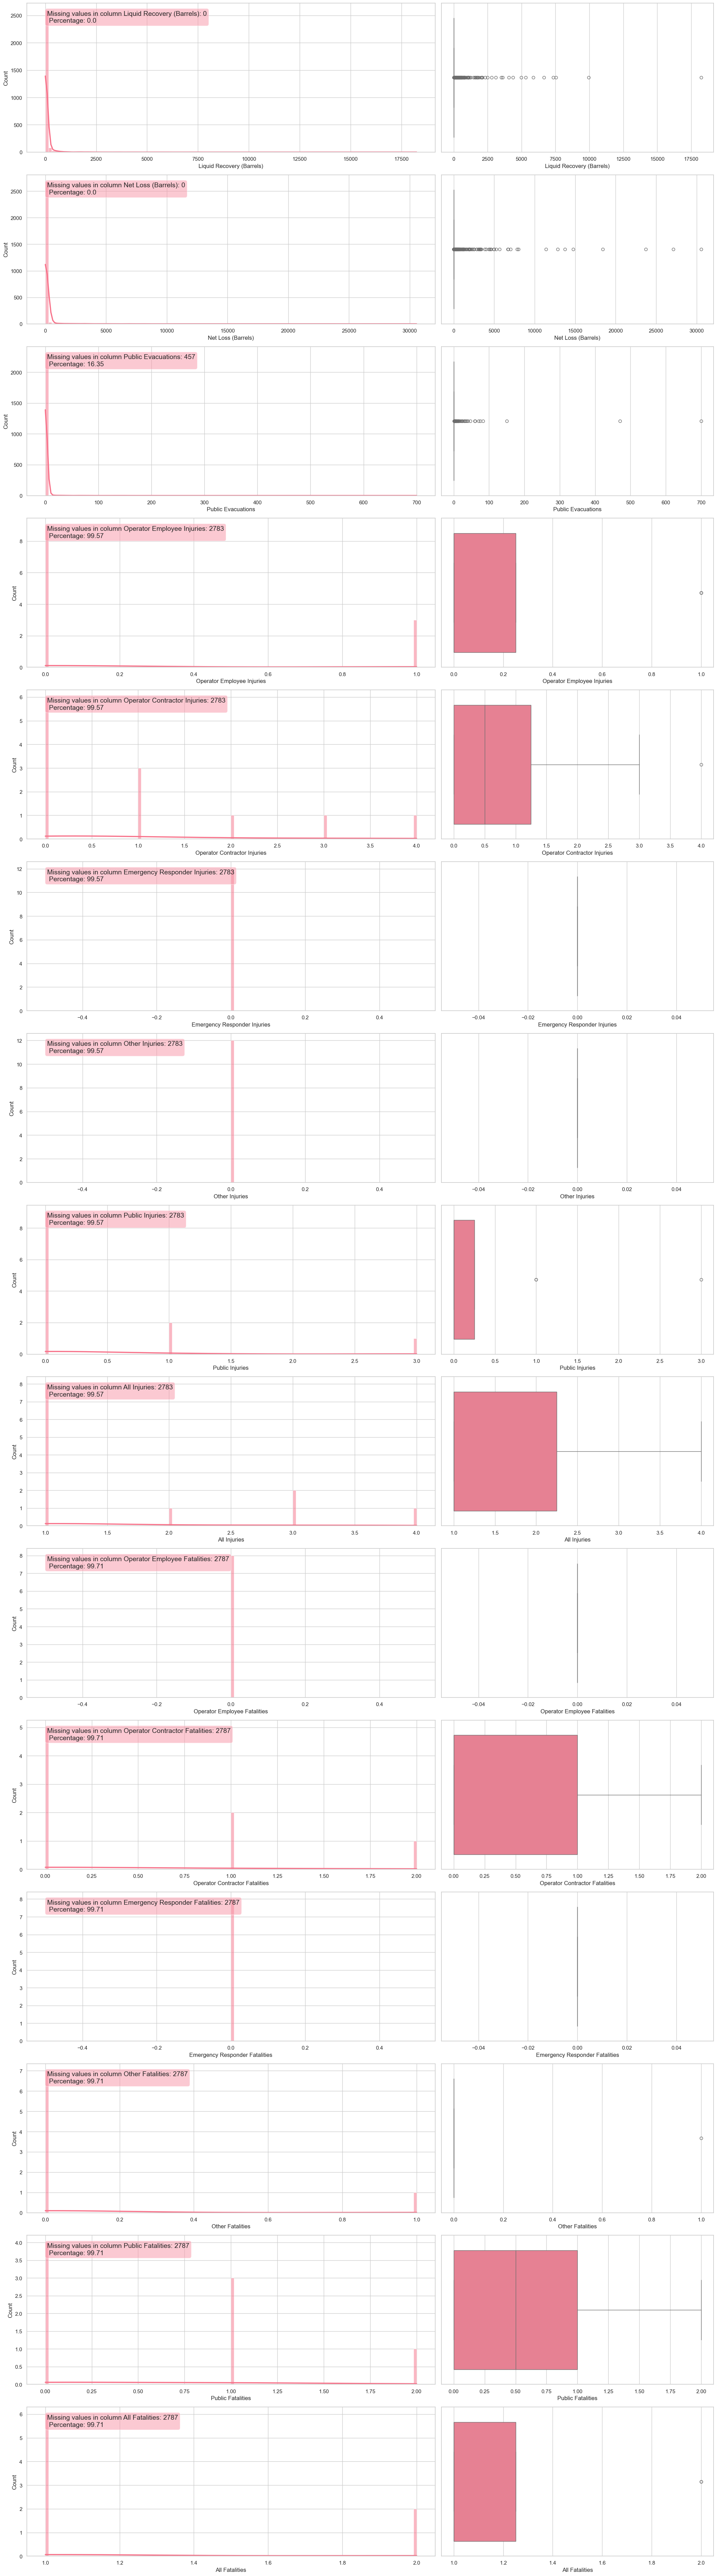

In [193]:
describe_stats_numerical(df[numerical[4:]], width_ratios=[0.6, 0.4])
plt.show()

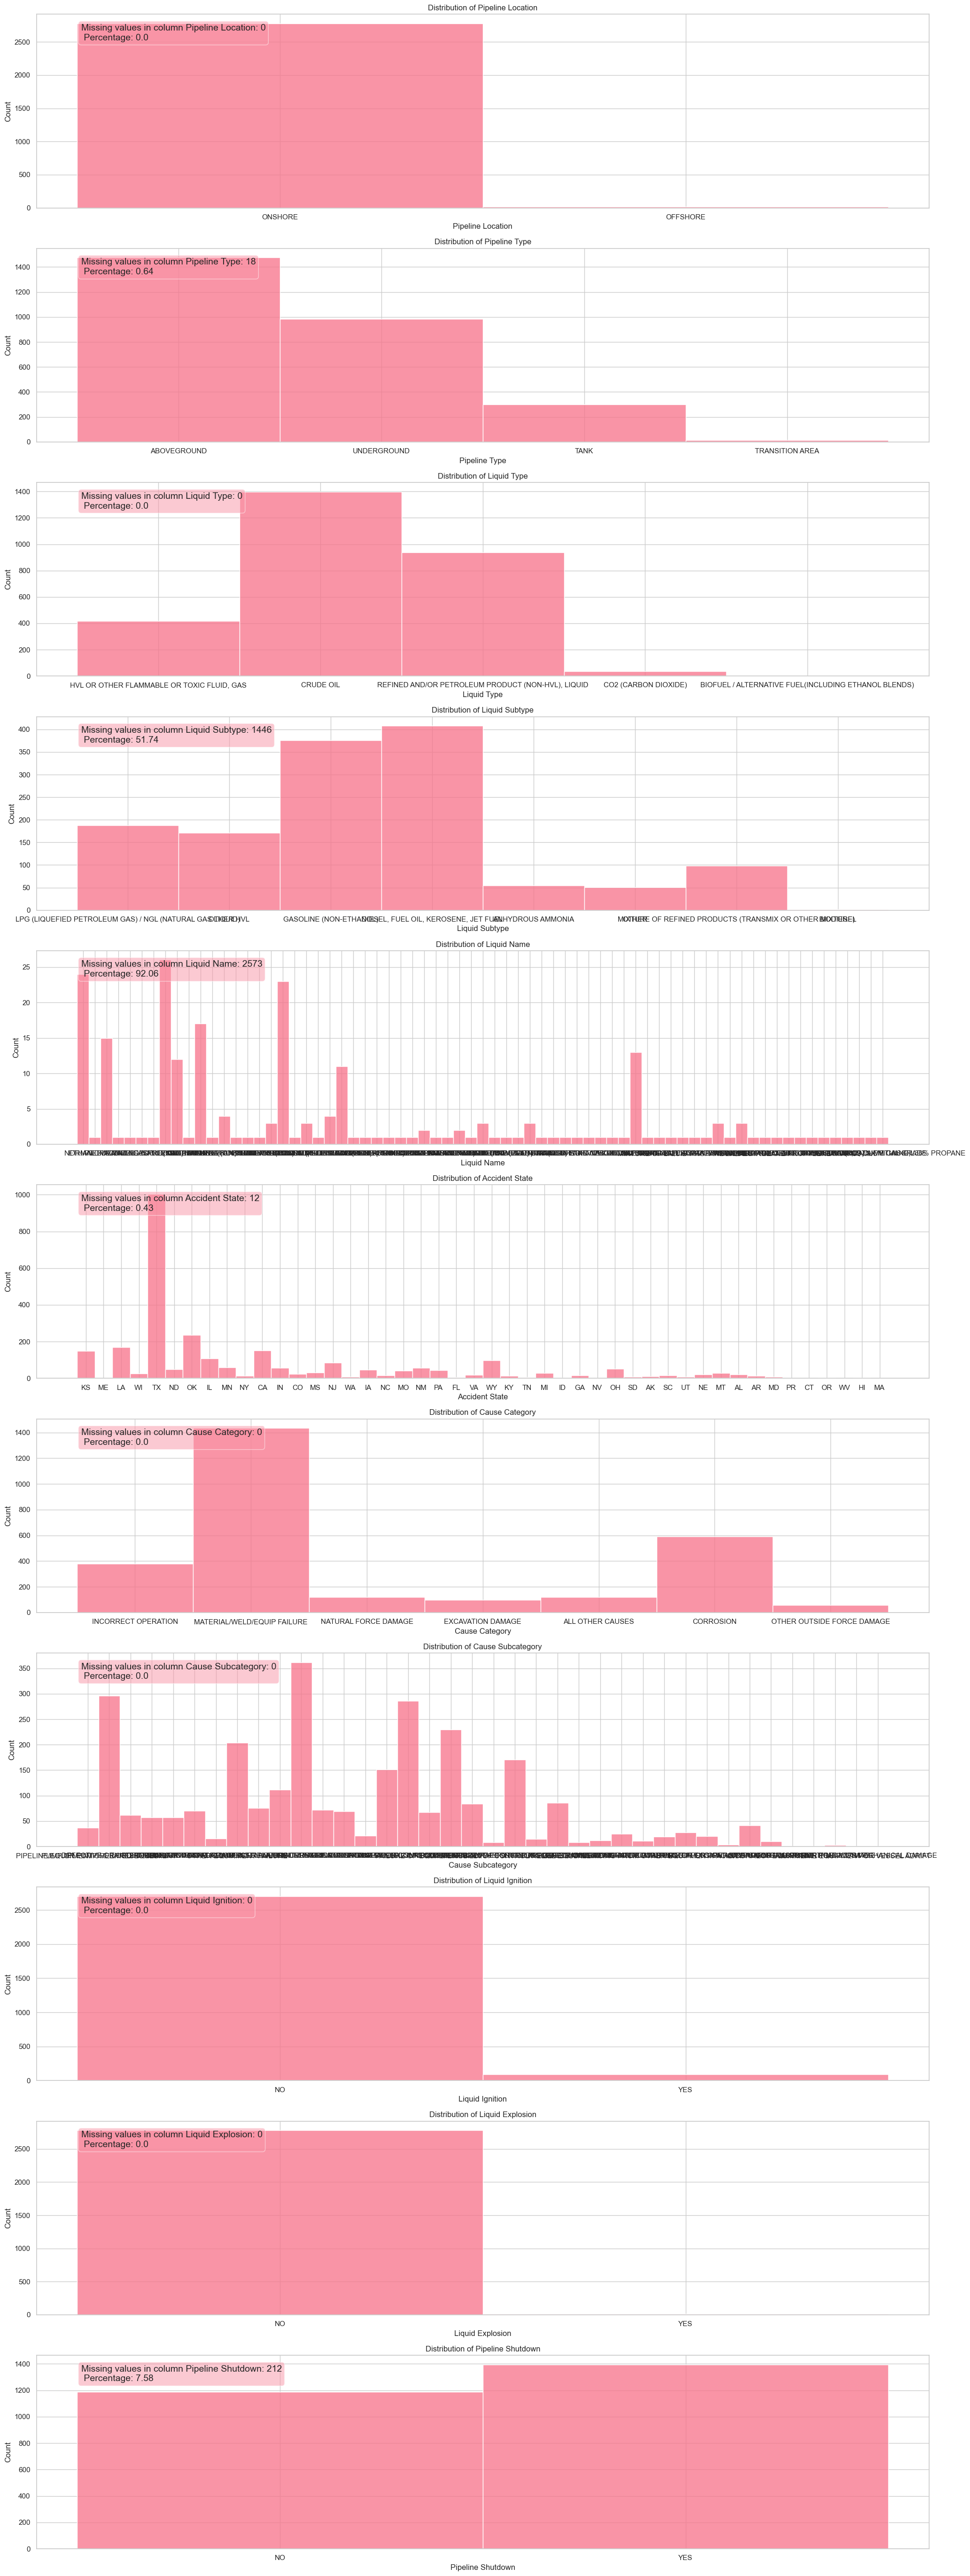

In [194]:
describe_stats_categorical(df[categorical])
plt.show()

In [42]:
def describe_target(df: pd.DataFrame, target: list) -> plt.Figure | plt.Axes:
    fig, axs = plt.subplots(len(target), 2,  width_ratios=[0.65, 0.35], figsize=(21, 5 * len(target)))
    
    for id, value in enumerate(target):
        stats = f"Missing values in column {value}: {df[value].isnull().sum()}\n Percentage: {round(df[value].isnull().sum() / df.shape[0] * 100, 2)}"
        axs[id][0].text(
            0.05, 0.95,
            stats,
            transform=axs[id][0].transAxes,
            fontsize=14,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='#f994a6', alpha=0.5)
        )
        sns.histplot(df, x=value, ax=axs[id][0], kde=True, bins=120)
        sns.boxplot(df, x=value, notch=True, ax=axs[id][1])
        axs[id][0].set(title = f'Distribution of {value}')

    fig.tight_layout()
    return fig, axs

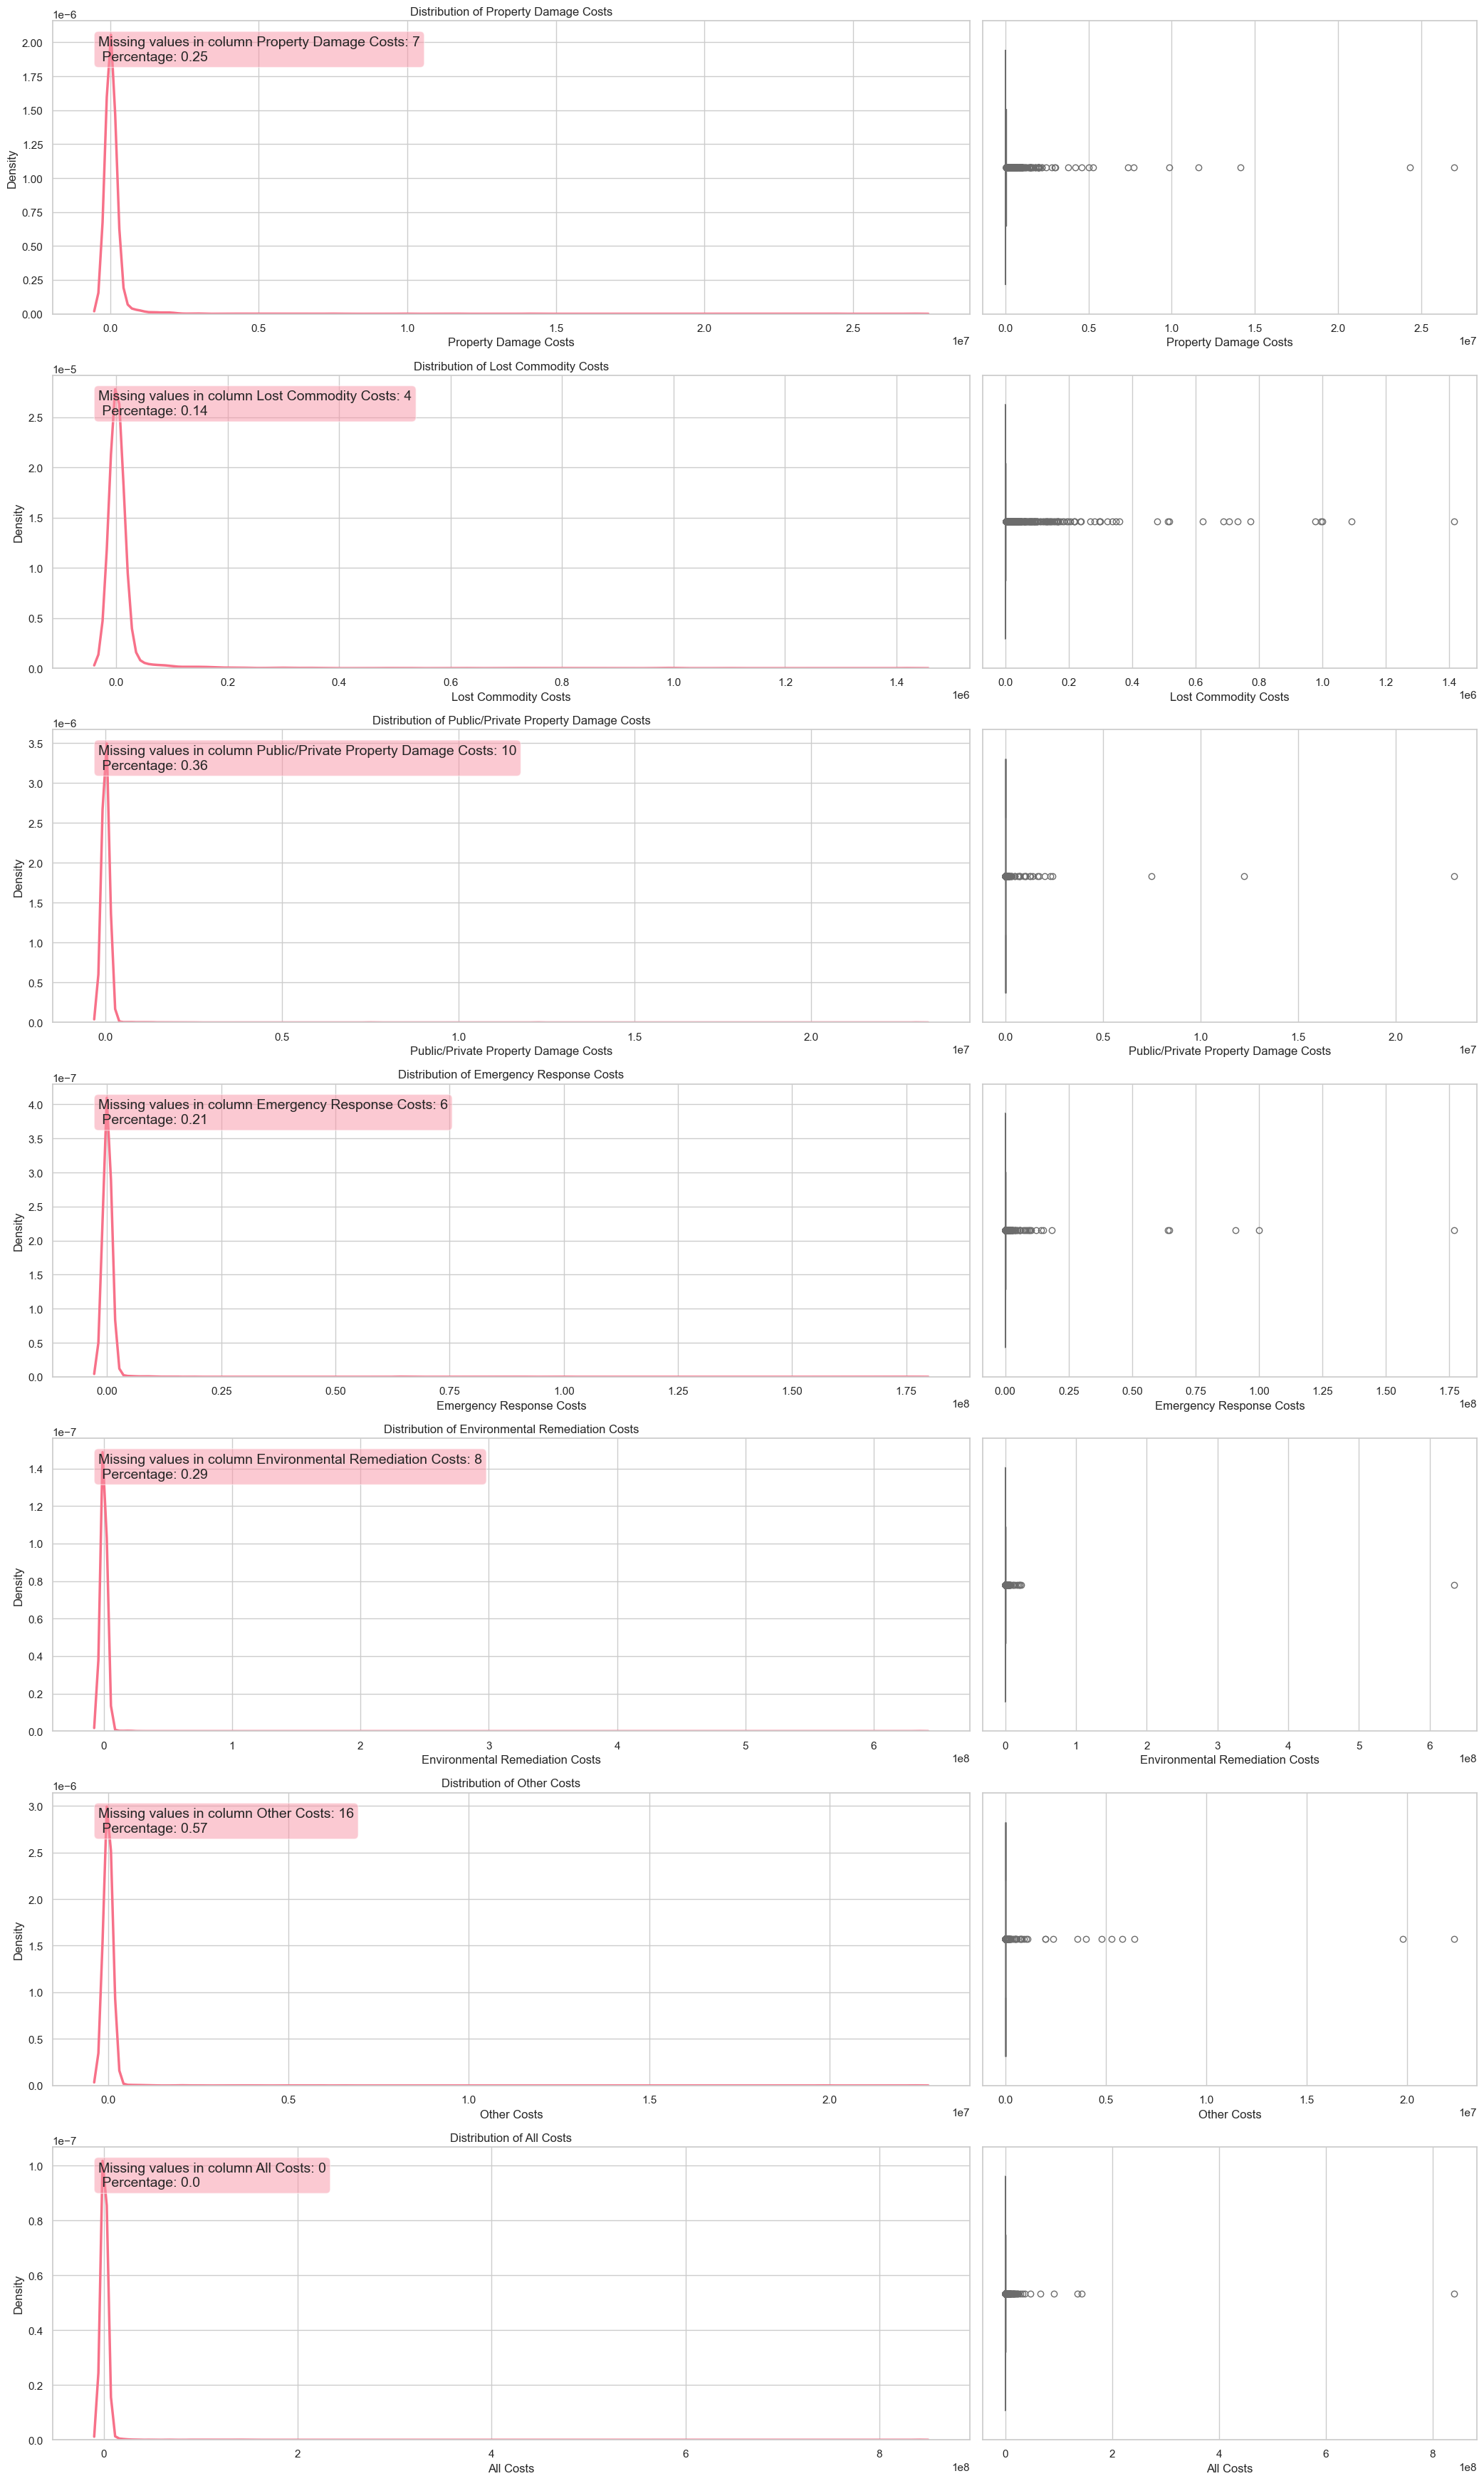

In [43]:
describe_target(df, target)
plt.show()

## Bivariate analysis

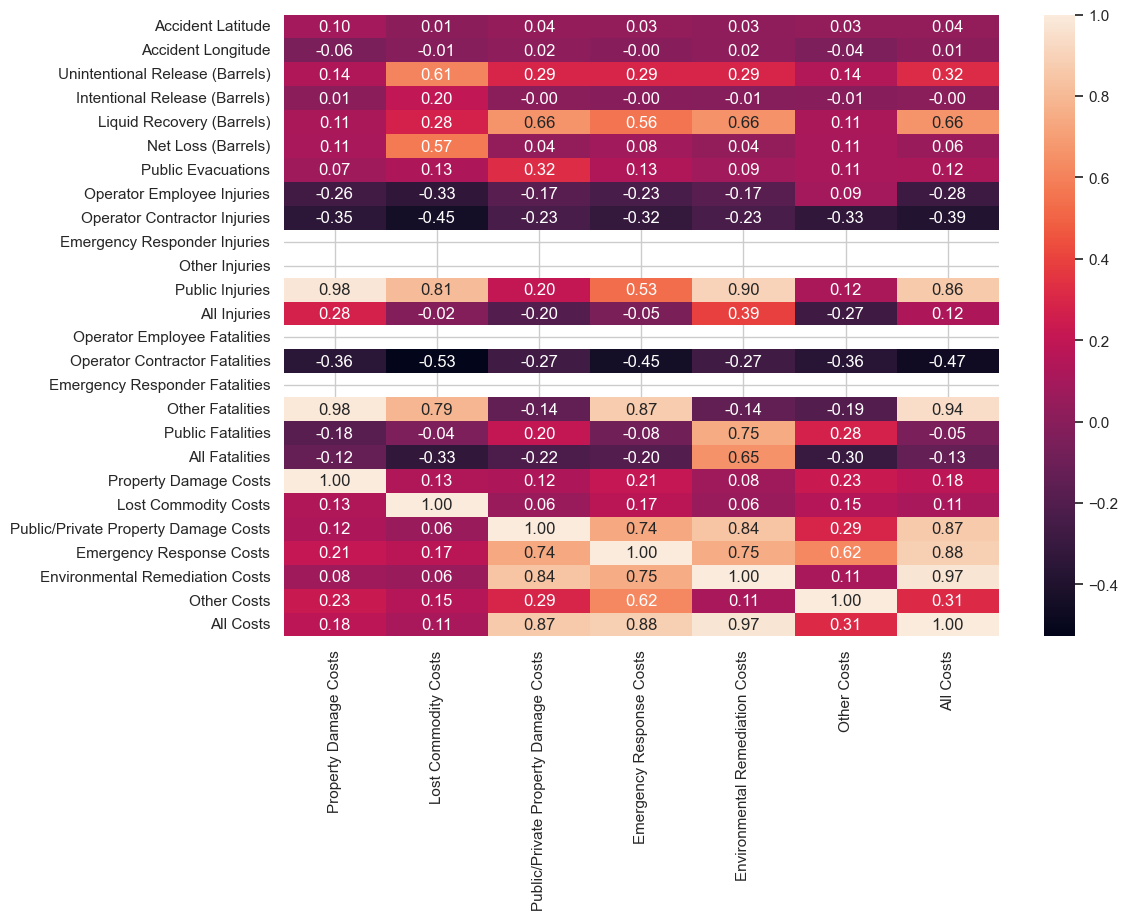

In [579]:
sns.heatmap(df.select_dtypes(include='number').corr().iloc[4:, -7:], annot=True, fmt='.2f')
plt.show()

In [383]:
def add_headers(
        fig,
        *,
        row_headers=None,
        col_headers=None,
        row_pad=1,
        col_pad=5,
        rotate_row_headers=True,
        **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

In [490]:
def bivariate_plot(df: pd.DataFrame, target: list, x: list, **func_kwargs: object) -> plt.Figure | plt.Axes:
    fig, axs = plt.subplots(nrows=len(x), ncols=len(target), figsize=(21, 5 * len(x)))
    
    for x_id, x_value in enumerate(x):
        for y_id, y_value in enumerate(target):
            sns.scatterplot(df, x = x_value, y = y_value, ax=axs[x_id, y_id]).set(xlabel='', ylabel='')
    
    add_headers(fig, row_headers=x, col_headers=target, col_pad=7)
    
    fig.tight_layout()
    return fig, axs

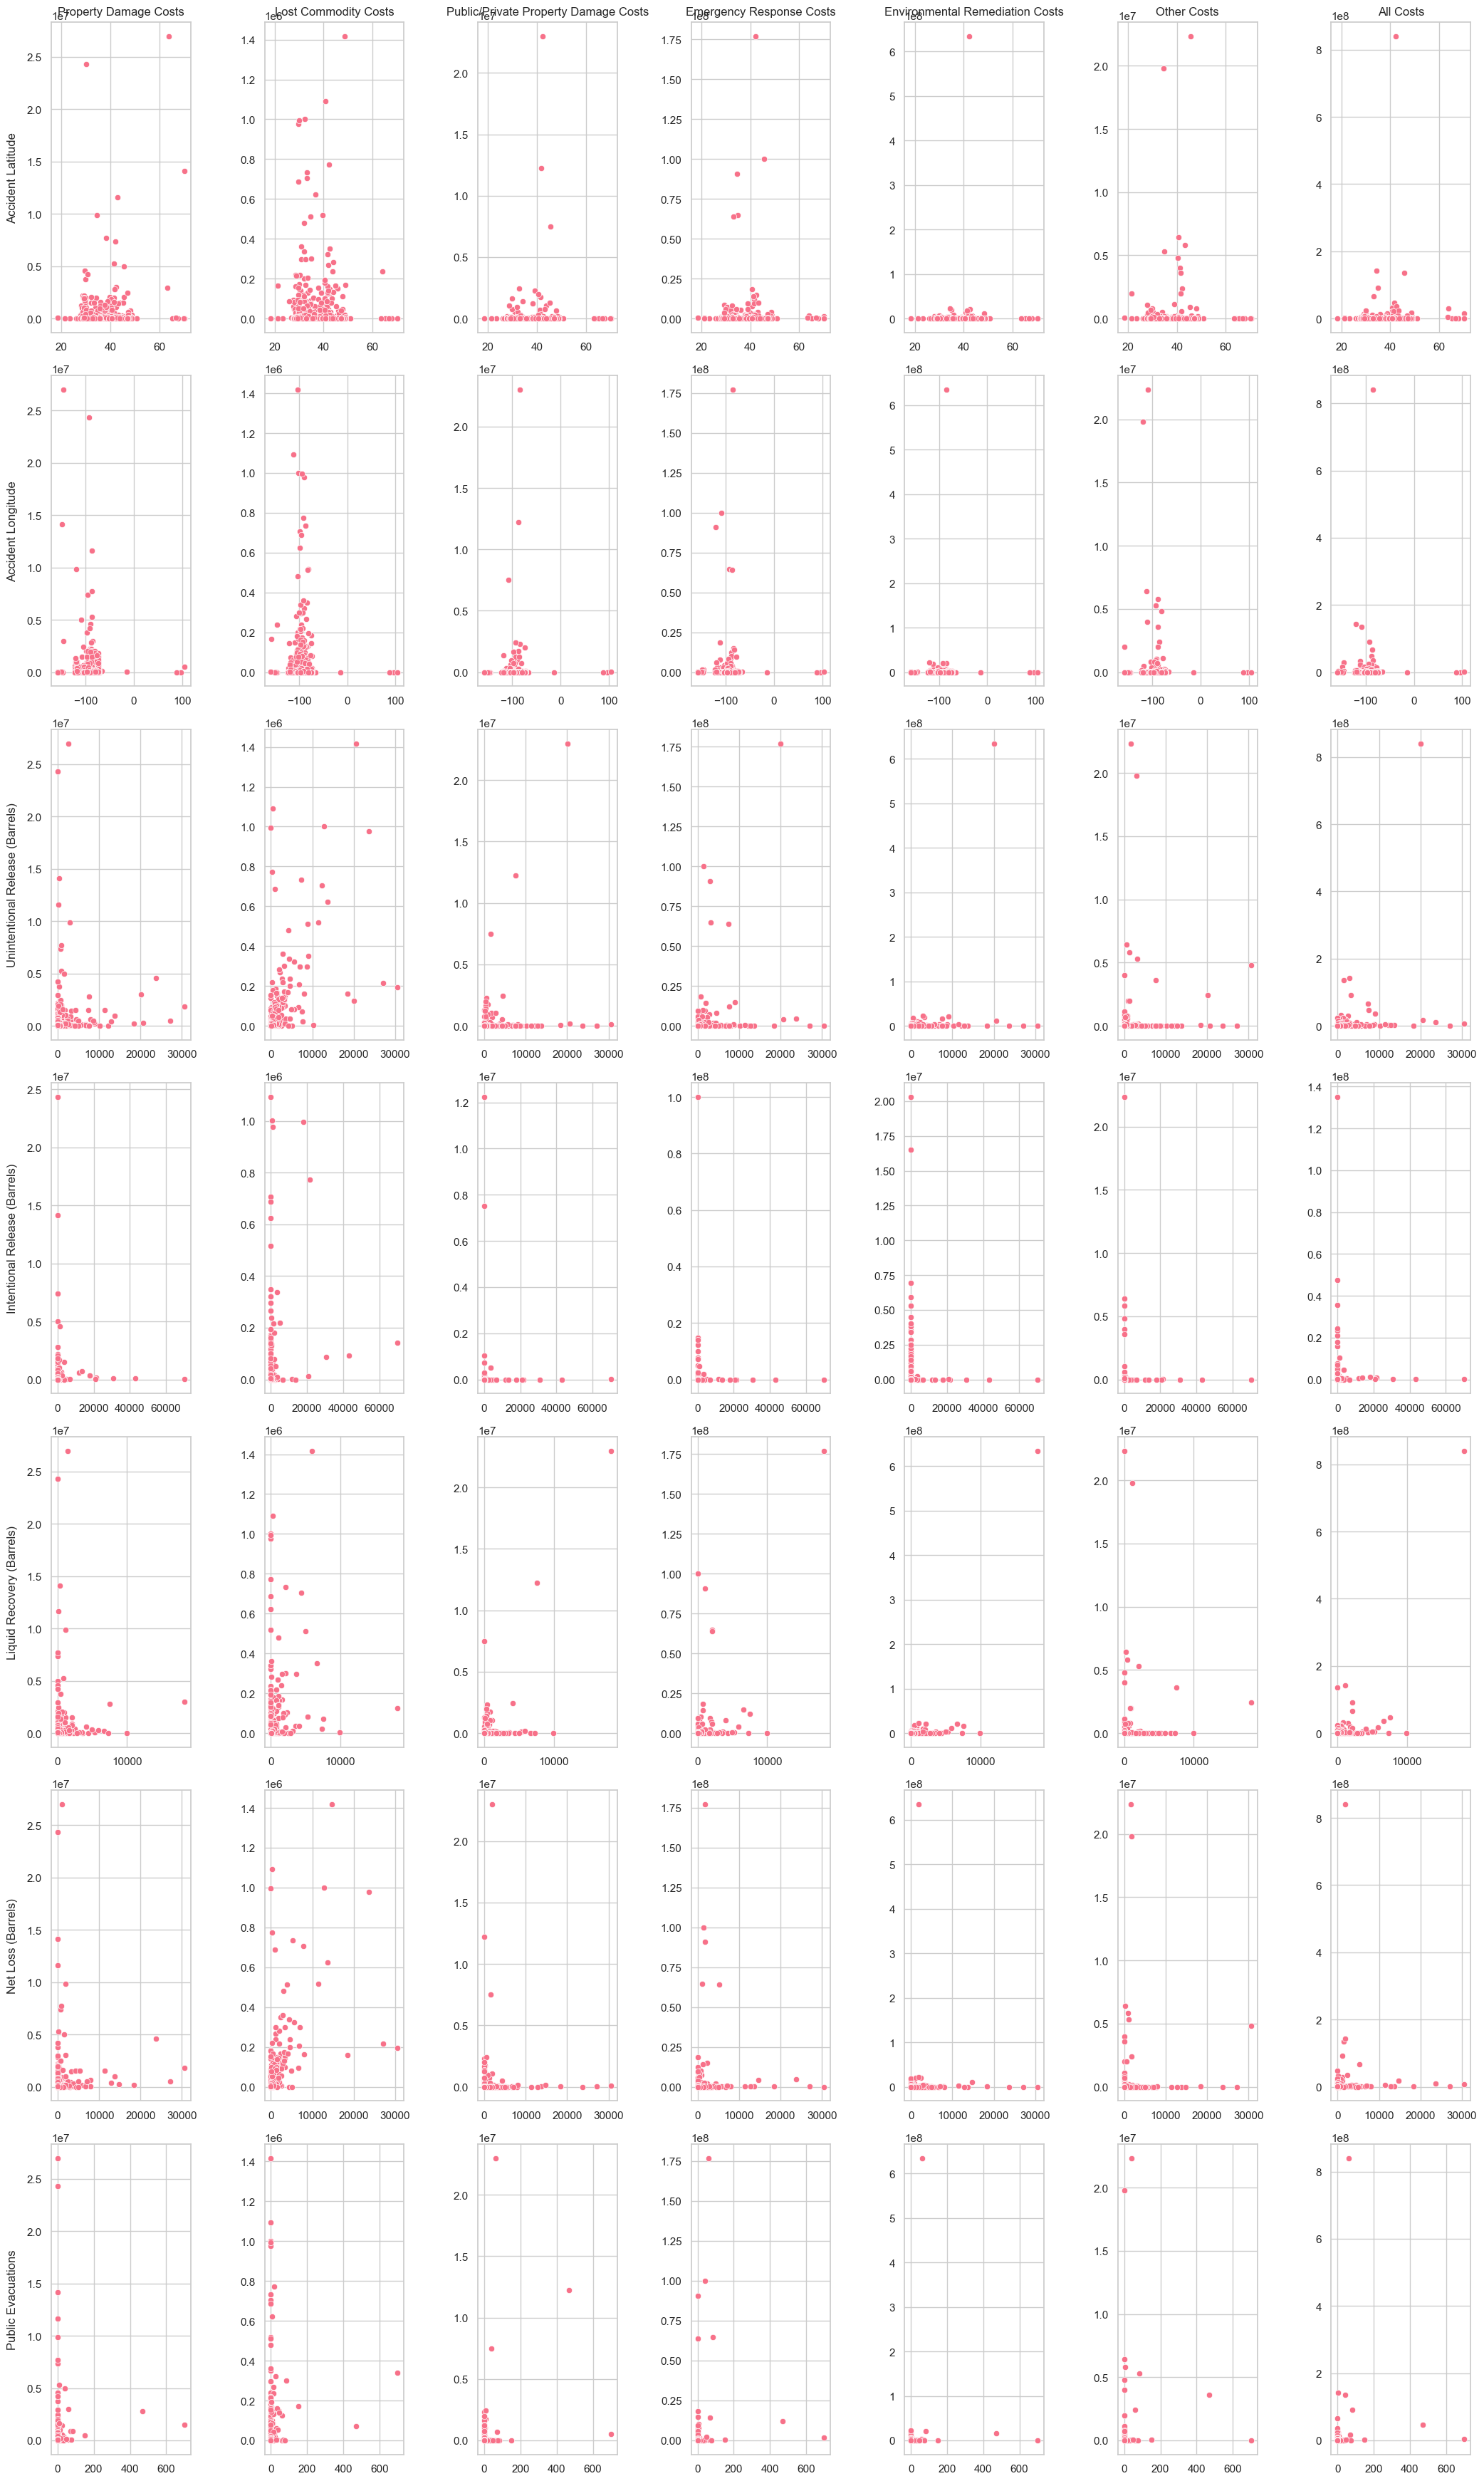

In [573]:
bivariate_plot(df, target, numerical[:7])
plt.show()

In [141]:
def kruskal_for_category(df, target, category):
    values = []
    filtered_data = df.dropna(subset=[category] + target)
    for i in filtered_data[category].unique():
        values.append(filtered_data.loc[filtered_data[category] == i, target])
    return sp.kruskal(*values, nan_policy='omit').pvalue

In [142]:
def kruskal_for_all(df, categorical, target):
    fig, axes = plt.subplots(nrows=round(len(categorical)/2), ncols=2, figsize=(21, 5 * len(categorical)))
    axes = axes.ravel()
    for id, value in enumerate(categorical):
        sns.barplot(x=kruskal_for_category(df, target, value), y=target, ax=axes[id])
        axes[id].set(title = f'Kruskal test for {value}', xlabel='pvalue', ylabel='target variable')
        axes[id].bar_label(axes[id].containers[0], fontsize=12)

    [fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
    sns.despine(fig=fig)
    fig.tight_layout()
    return fig, axes

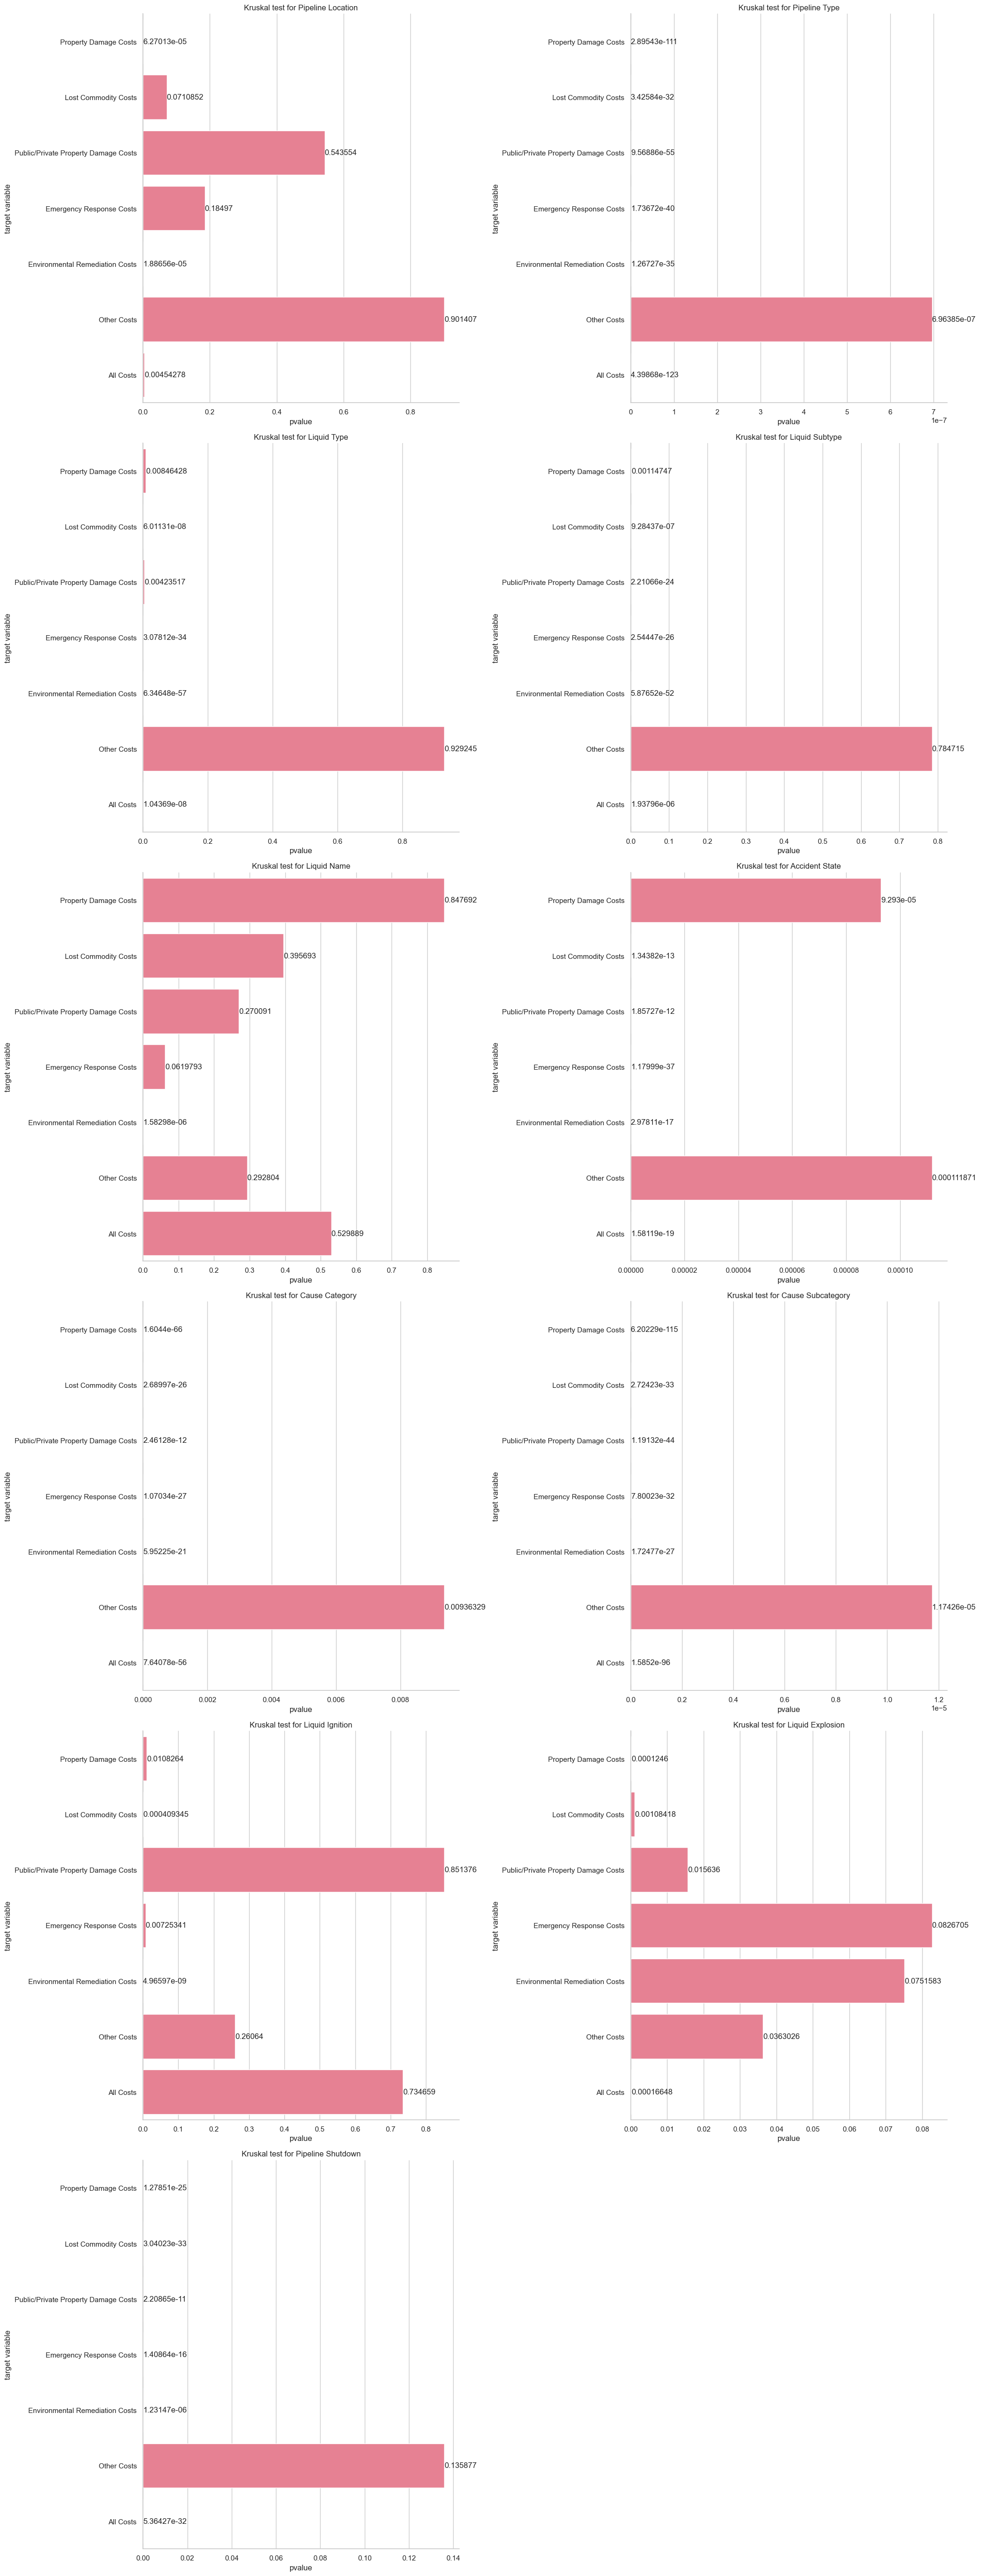

In [143]:
kruskal_for_all(df, categorical, target)
plt.show()

## Data splitting

In [360]:
df_cool = df.dropna(subset=target)
x_train_raw, x_test_raw, y_train, y_test = train_test_split(df_cool.loc[:, [i not in target for i in df.columns]],
                                                            df_cool[target], test_size=0.2, random_state=6578)

## Data Preprocessing

In [156]:
class DateDiff(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        copy = X.copy()
        copy = copy[:, 1:]
        copy = pd.DataFrame(copy)
        copy = copy.astype('datetime64[ns]')
        copy = (copy.to_numpy()[:, 1] - copy.to_numpy()[:, 0])
        copy[np.isnan(copy)] = 0
        return copy.astype(np.int64)
    
    def fit_transform(self, X, y=None, **fit_kwargs):
        return self.transform(X)

In [157]:
class DateToMonth(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        copy = X.copy()
        copy = pd.DataFrame(copy)
        copy = copy.astype('datetime64[ns]')
        return (copy[0].dt.month).to_numpy().reshape(-1, 1)
    
    def fit_transform(self, X, y=None, **fit_params):
        copy = X.copy()
        copy = pd.DataFrame(copy)
        copy = copy.astype('datetime64[ns]')
        return (copy[0].dt.month).to_numpy().reshape(-1, 1)
    
class DateToDay(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        copy = X.copy()
        copy = pd.DataFrame(copy)
        copy = copy.astype('datetime64[ns]')
        return (copy[0].dt.day).to_numpy().reshape(-1, 1)

    def fit_transform(self, X, y=None, **fit_params):
        copy = X.copy()
        copy = pd.DataFrame(copy)
        copy = copy.astype('datetime64[ns]')
        return (copy[0].dt.day).to_numpy().reshape(-1, 1)

class DateToNSM(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        copy = X.copy()
        copy = pd.DataFrame(copy)
        copy = copy.astype('datetime64[ns]')
        return (copy[0].dt.hour * 3600 + copy[0].dt.minute * 60 + copy[0].dt.second).to_numpy()
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.transform(X)

In [158]:
class BinaryEncoder(TransformerMixin):
    def __init__(self):
        self.func = None

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        copy = X.copy()
        copy[~pd.isna(copy)] = 1
        copy = copy.copy()
        copy[pd.isna(copy)] = 0
        return copy.astype(np.int32)
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.transform(X)

In [598]:
mapper = DataFrameMapper(
    [(['Pipeline Shutdown', 'Shutdown Date/Time', 'Restart Date/Time'], DateDiff(), {'alias': 'Shutdown duration'})]+
     [(['Public Evacuations', 'Unintentional Release (Barrels)', 'Liquid Recovery (Barrels)', 'Net Loss (Barrels)'], 
            [KNNImputer(), FunctionTransformer(func=np.log1p), PolynomialFeatures(degree=3, include_bias=True)])]
    + gen_features(
        columns=[[i] for i in df.iloc[:, 29:41].columns],
        classes=[{'class': SimpleImputer, 'strategy': 'constant', 'fill_value': 0}],
    ) +
    gen_features(
        columns=[['Accident Date/Time']],
        classes=[DateToMonth, RepeatingBasisFunction],
        prefix='month'
    ) + gen_features(
        columns=[['Accident Date/Time']],
        classes=[DateToMonth, {'class': RepeatingBasisFunction, 'n_periods': 7}],
        prefix='day'
    ) +
    gen_features(
        columns=[['Accident Date/Time']],
        classes=[DateToNSM]
    ) + gen_features(
        columns=[['Pipeline Type', 'Accident State']],
        classes=[{'class': SimpleImputer, 'strategy': 'most_frequent'}]
    ) +
    gen_features(
        columns=['Liquid Subtype', 'Liquid Name', 'Intentional Release (Barrels)'],
        classes=[BinaryEncoder]
    ) +
    gen_features(
        columns=[['Public Evacuations']],
        classes=[KNNImputer]
    ),
    df_out=True,
    default=None,
    drop_cols=to_drop
)
mapper.fit(x_train_raw)

DataFrameMapper(default=None, df_out=True,
                drop_cols=['Report Number', 'Supplemental Number',
                           'Accident Year', 'Operator ID', 'Accident Year',
                           'Operator Name', 'Pipeline/Facility Name',
                           'Accident City', 'Accident County'],
                features=[(['Pipeline Shutdown', 'Shutdown Date/Time',
                            'Restart Date/Time'],
                           <__main__.DateDiff object at 0x000002D0D891EC30>,
                           {'alias': 'Shutdown duration'}),...
                          (['Pipeline Type', 'Accident State'],
                           [SimpleImputer(strategy='most_frequent')], {}),
                          ('Liquid Subtype',
                           [<__main__.BinaryEncoder object at 0x000002D0DC83A480>],
                           {}),
                          ('Liquid Name',
                           [<__main__.BinaryEncoder object at 0x000002D0DC83B350>],
                           {}),
                          ('Intentional Release (Barrels)',
                           [<__main__.BinaryEncoder object at 0x000002D0DC83A720>],
                           {}),
                          (['Public Evacuations'], [KNNImputer()], {})])

In [599]:
x_train = mapper.transform(x_train_raw)
x_test = mapper.transform(x_test_raw)

In [590]:
model_template = AutoML(task='regression', metric='r2',
               time_budget=180, estimator_list=['xgboost', 'rf', 'extra_tree'],
                early_stop=True,  n_splits=3, eval_method='cv', verbose=0)

In [591]:
model = MultiOutputRegressor(model_template, n_jobs=8)

In [592]:
model.fit(x_train, y_train)

MultiOutputRegressor(estimator=AutoML(append_log=False, auto_augment=True,
                                      custom_hp={}, cv_score_agg_func=None,
                                      early_stop=True, ensemble=False,
                                      estimator_list=['xgboost', 'rf',
                                                      'extra_tree'],
                                      eval_method='cv',
                                      fit_kwargs_by_estimator={},
                                      force_cancel=False, free_mem_ratio=0,
                                      hpo_method='auto',
                                      keep_search_state=False,
                                      learner_selector='sample',
                                      log_file_name='',
                                      log_training_metric=False,
                                      log_type='better', max_iter=None,
                                      mem_thres=4294967296, metric='r2',
                                      metric_constraints=[],
                                      min_sample_size=10000,
                                      mlflow_logging=True, model_history=False,
                                      n_concurrent_trials=1, n_jobs=-1,
                                      n_splits=3, pred_time_limit=inf,
                                      preserve_checkpoint=True,
                                      retrain_full=True, ...),
                     n_jobs=8)

In [386]:
# with open('model.pkl', 'wb') as f:
    # pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

In [595]:
model= pickle.load(open('logs/automl.pkl', 'rb'))

## Model Evaluation

In [390]:
def residuals_distribution(y: pd.DataFrame, y_predicted: pd.DataFrame, **plot_kw: object) -> object:
    residuals = y - y_predicted

    plot = sns.kdeplot(x=residuals, fill=True, **plot_kw)
    plot.set(xlabel='Residual', ylabel='Distribution', title='Residuals distribution')
    return plot


def prediction_plot(y: pd.DataFrame, y_predicted: pd.DataFrame, **plot_kw: object) -> object:
    plot = sns.lineplot(x=y, y=y, color='black', alpha=0.5, **plot_kw)
    plot.scatter(y=y_predicted, x=y)
    plot.set(ylabel='Residual', xlabel='Y')
    return plot


def residuals_plot(y: pd.DataFrame, y_predicted: pd.DataFrame, line: bool = True, **plot_kw: object) -> object:
    residuals = y - y_predicted
    plot = sns.scatterplot(y=y, x=residuals, **plot_kw)
    plot.set(xlabel='Residual', ylabel='Y', title='Y to Y residuals')
    if line:
        plot.axvline(color='black', alpha=0.5)
    return plot


def residual_analysis(y: pd.DataFrame, y_predicted: pd.DataFrame, fig, axs, **plot_kw: object) -> object:
    residuals_distribution(y, y_predicted, ax=axs[2], **plot_kw)
    prediction_plot(y, y_predicted, ax=axs[0], **plot_kw)
    residuals_plot(y, y_predicted, ax=axs[1], **plot_kw)

    return (fig, axs)

In [391]:
def results(y_true, y_pred):
    results = pd.DataFrame(index=['R2', 'MSE', 'MAE'])
    for id, value in enumerate(target):
        target_result = {'R2': r2_score(y_true[:, id], y_pred[:, id]),
                         'MSE': mean_squared_error(y_true[:, id], y_pred[:, id]),
                         'MAE': mean_absolute_error(y_true[:, id], y_pred[:, id])}
        results[value] = target_result
    return results

In [567]:
def plot_results(y_true, y_pred):
    fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(21, 21))
    for i in range(y_true.shape[1]):
        residual_analysis(y_true[:, i], y_pred[:, i], fig, axes[i, :])
    add_headers(fig, row_headers=target)
    fig.tight_layout()
    return fig, axes

In [639]:
results(y_test.to_numpy(), model.predict(x_test))

Property Damage Costs  Lost Commodity Costs  \
R2                  0.2621                0.3416   
MSE    64,047,771,460.3648    4,841,545,866.5964   
MAE           103,058.3693           11,580.8758   

     Public/Private Property Damage Costs  Emergency Response Costs  \
R2                                 0.0325                    0.0280   
MSE                  921,458,462,408.8981   62,518,905,462,209.5000   
MAE                           62,003.4037              687,215.6640   

     Environmental Remediation Costs         Other Costs  \
R2                            0.0028              0.1662   
MSE         723,422,049,342,814.5000 53,862,143,817.9061   
MAE                   1,341,101.2058         54,622.3003   

                     All Costs  
R2                      0.0666  
MSE 1,199,985,132,991,519.5000  
MAE             2,187,529.4771

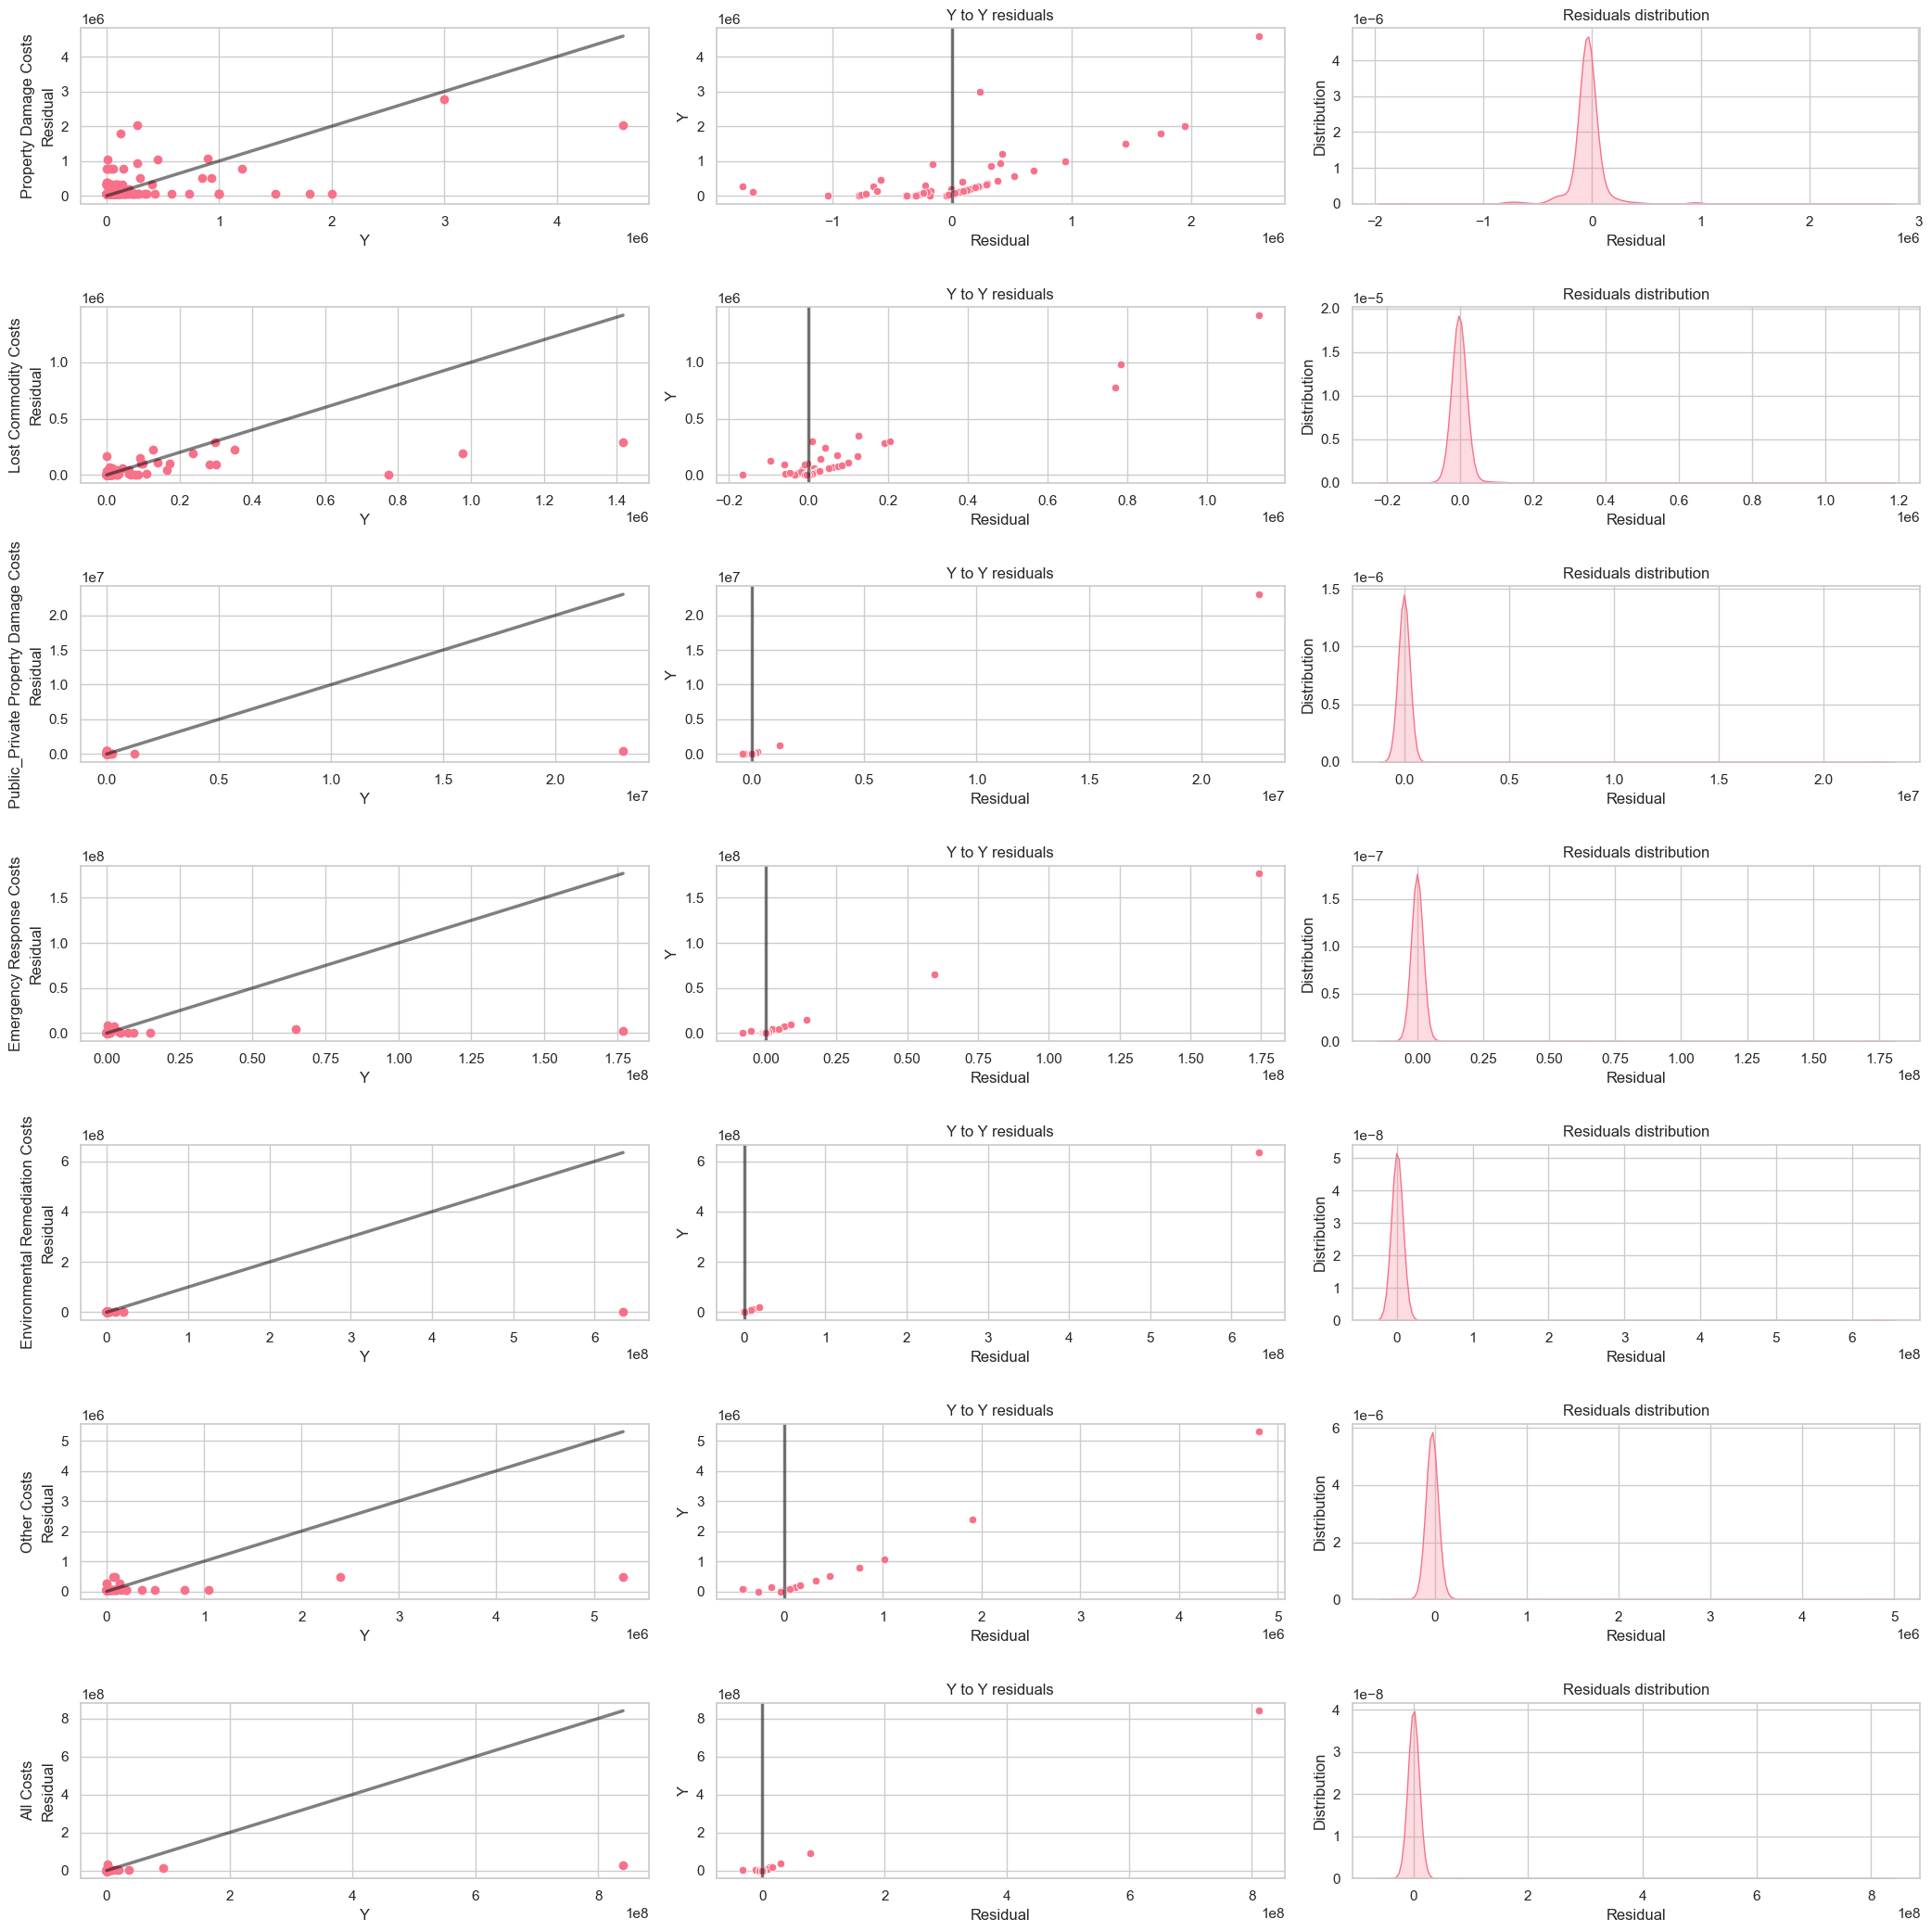

In [570]:
fig, axes = plot_results(y_test.to_numpy(), model.predict(x_test))
plt.show()
fig.savefig(r'img/residuals analysis.png')

In [487]:
def feature_importance(features, values, ax, title):
    sns.barplot(x=values, y=features, ax=ax).set(title = title)
    ax.bar_label(ax.containers[0], fontsize=12)
    
def plot_feature_importance(model):
    fig, axes = plt.subplots(nrows=len(model.estimators_),  figsize=(21, 5 * len(model.estimators_)))
    axes = axes.ravel()
    for id, value in enumerate(model.estimators_):
        val = pd.DataFrame()  
        val['Importance'] = value.feature_importances_
        val['feature'] = value.feature_names_in_
        val.sort_values(by=['Importance'], ascending=False, inplace=True)
        val = val.iloc[:10]
        feature_importance(val['feature'], val['Importance'], axes[id], f'Feature Importance for {target[id]}')
        
    [fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
    sns.despine()
    fig.tight_layout()
    return fig, axes
    

In [606]:
def plot_learning_curve(filename, ax, title):
    time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(
        filename=filename, time_budget=30)
    time_history, best_valid_loss_history = np.array(time_history), np.array(best_valid_loss_history)
    ax.step(time_history, 1 - best_valid_loss_history, where='post')
    sns.scatterplot(y=1 - best_valid_loss_history, x=time_history, s=100, ax=ax).set(title=title, xlabel='Wall Clock Time (s)', ylabel='Validation r2')
    for i in range(len(best_valid_loss_history)):
        ax.text(time_history[i] - time_history.mean()/100, 1 - np.array(best_valid_loss_history)[i] + best_valid_loss_history.mean()/100, str(1 - np.array(best_valid_loss_history)[i])[:5],
                 fontsize=10)

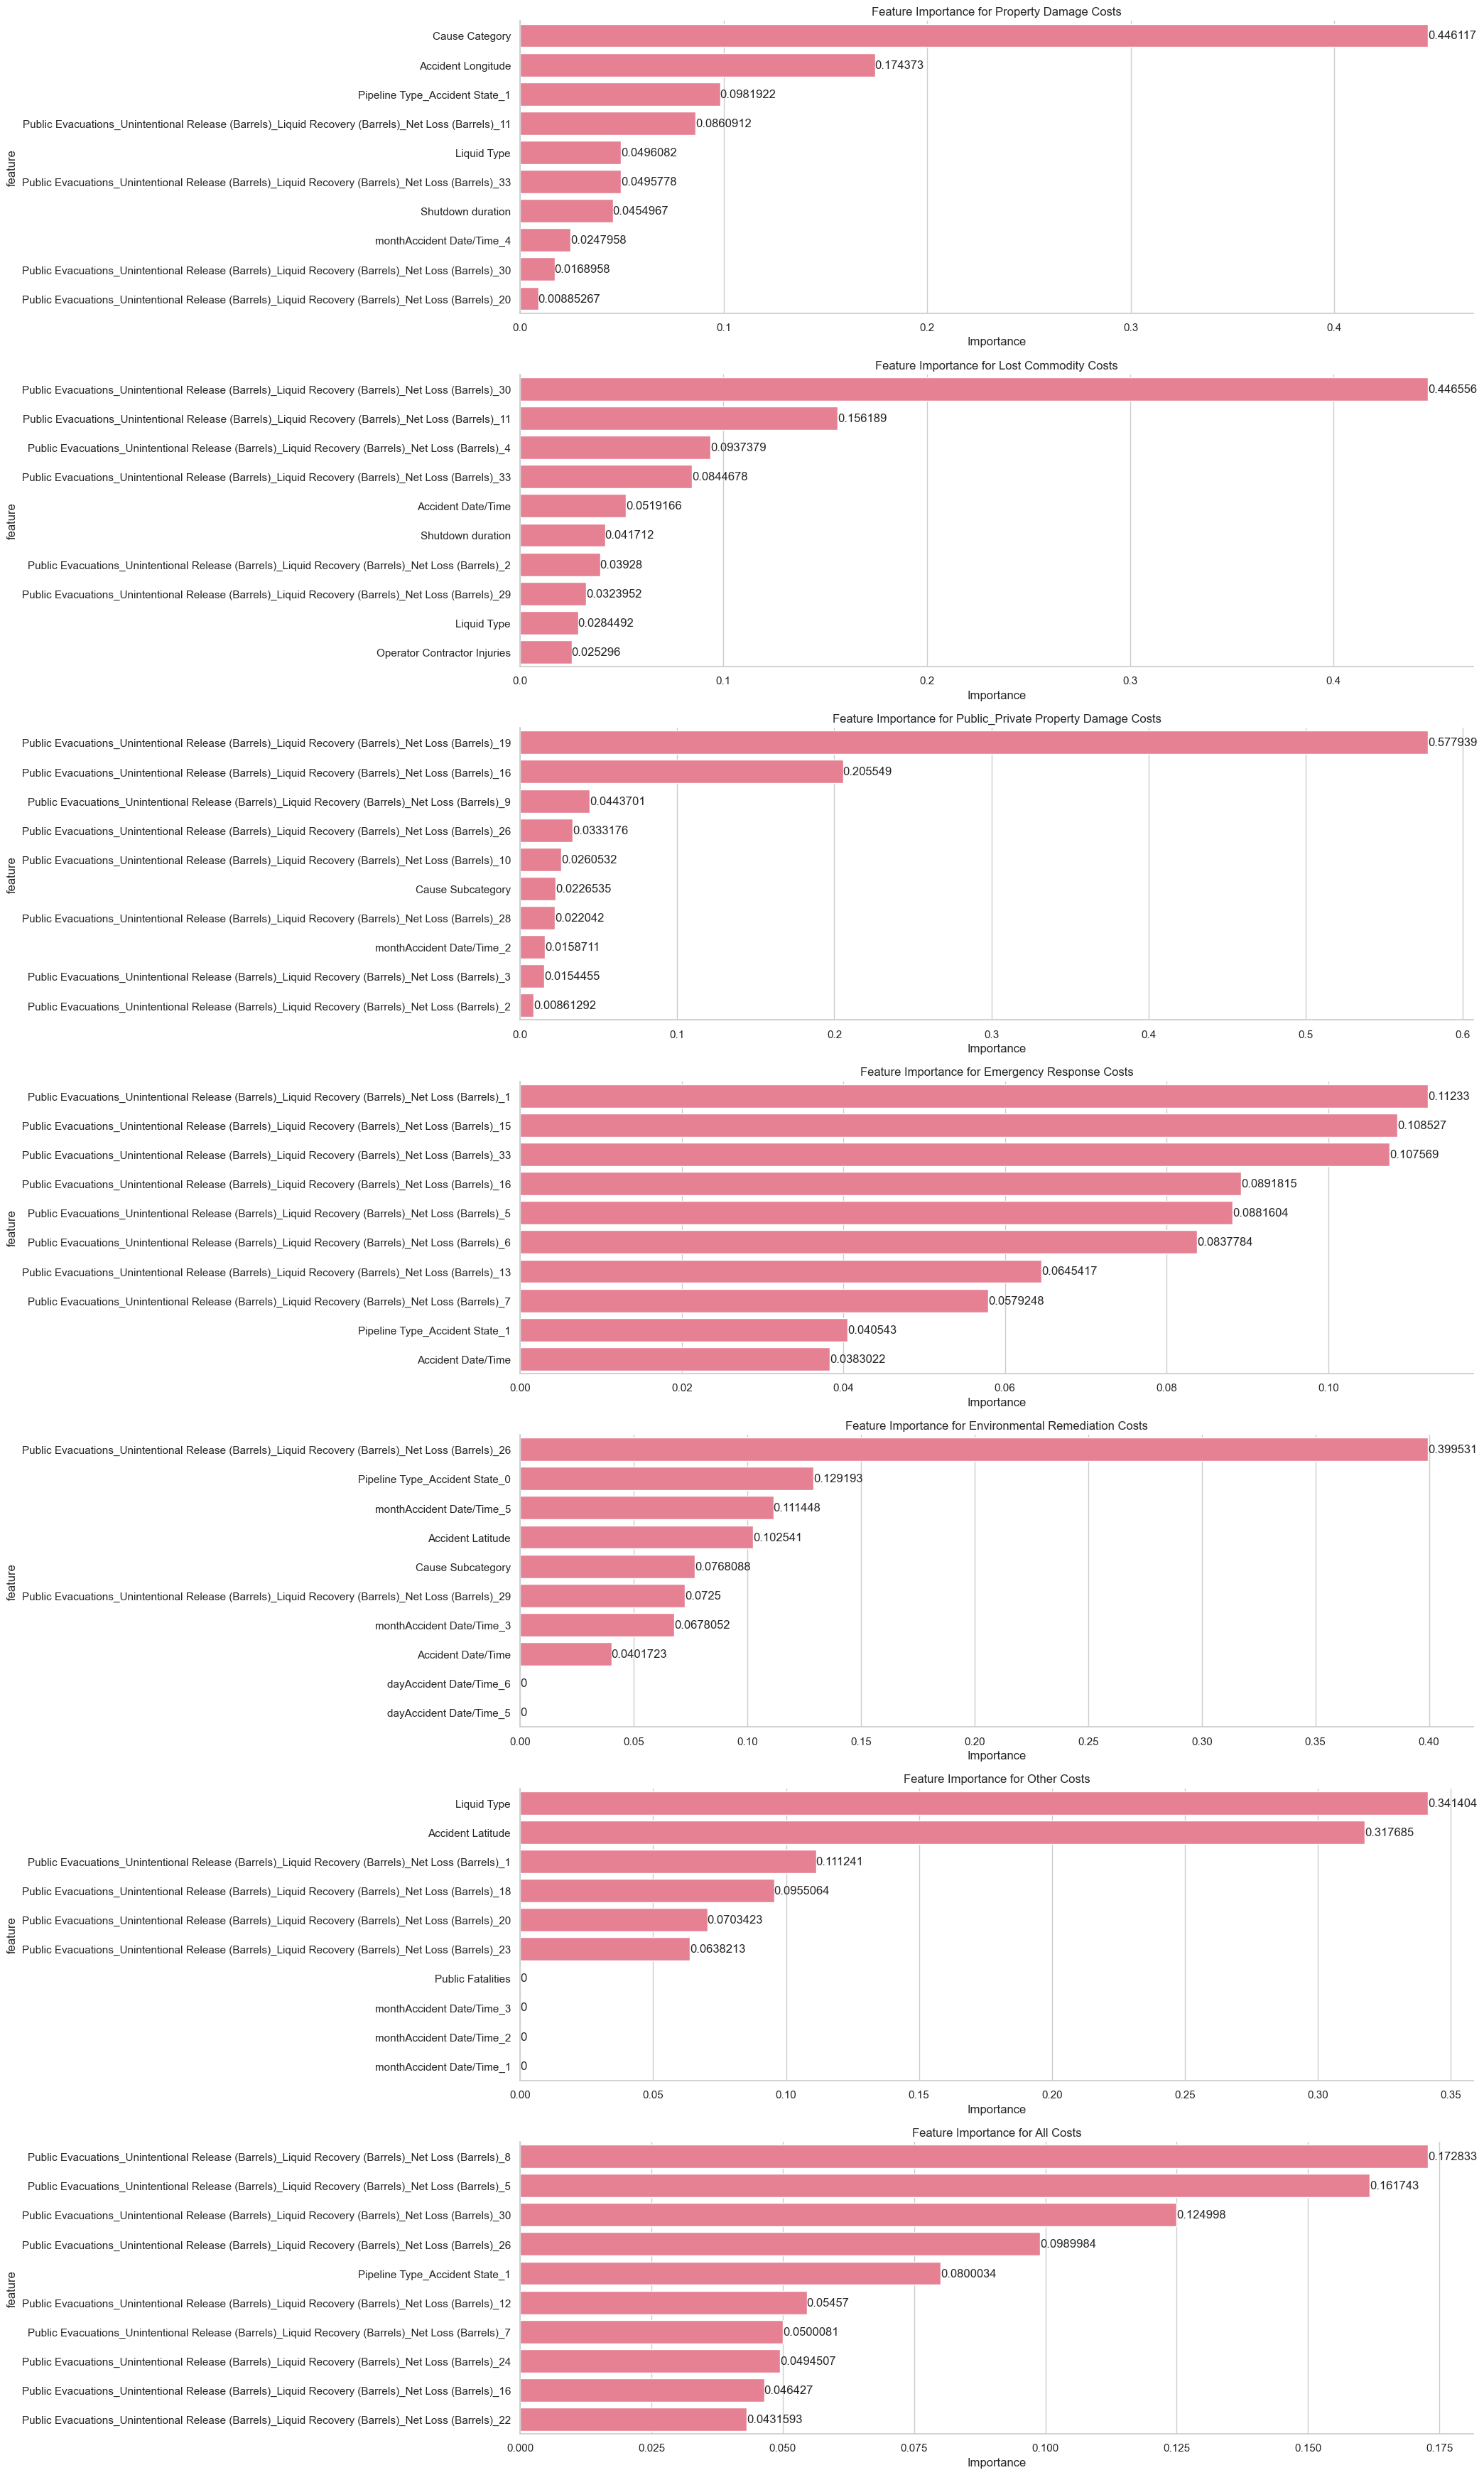

In [565]:
fig, axes = plot_feature_importance(model)
plt.show()

In [509]:
def learn_model(x_train, y_train, target, estimator):
    model = AutoML(task='regression', metric='r2',
                   time_budget=30, estimator_list=estimator,
                   early_stop=True, n_splits=3, eval_method='cv', verbose=0, log_file_name=str(target) + '.log')
    model.fit(x_train, y_train)
    return None

In [601]:
def create_logs(x, y, targets, estimators, filenames):
    logs = []
    for id, value in enumerate(targets):
        learn_model(x, y[:, id], value, estimators[id])
        logs.append(r'logs/'+str(filenames[id])+'.log')
    return logs

In [529]:
filenames = target
for id, value in enumerate(filenames):
    filenames[id] = re.sub(r'\/', '_', value)

In [533]:
ll = create_logs(x_train, y_train.to_numpy(), target, [['xgboost']] * 6 + [['extra_tree']], filenames)

C:\Users\dooge\ML\ML\.venv\Lib\site-packages\flaml\automl\data.py:306: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].fillna("__NAN__")
C:\Users\dooge\ML\ML\.venv\Lib\site-packages\flaml\automl\data.py:306: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].fillna("__NAN__")
C:\Users\dooge\ML\ML\.venv\Lib\site-packages\flaml\automl\data.py:306: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To 

['Property Damage Costs.log',
 'Lost Commodity Costs.log',
 'Public_Private Property Damage Costs.log',
 'Emergency Response Costs.log',
 'Environmental Remediation Costs.log',
 'Other Costs.log',
 'All Costs.log']

In [612]:
def plot_learning(filenames, targets):
    fig, axes = plt.subplots(nrows=3, ncols=3,  figsize=(21, 21))
    axes = axes.ravel()
    for id, value in enumerate(targets):
        if id == 6:
            plot_learning_curve(r'logs/'+filenames[id]+'.log', axes[id+1], f'Learning curve for {value}')
        else:
            plot_learning_curve(r'logs/'+filenames[id] + '.log', axes[id], f'Learning curve for {value}')
            
    [fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]      
    fig.tight_layout()
    return fig, axes
        

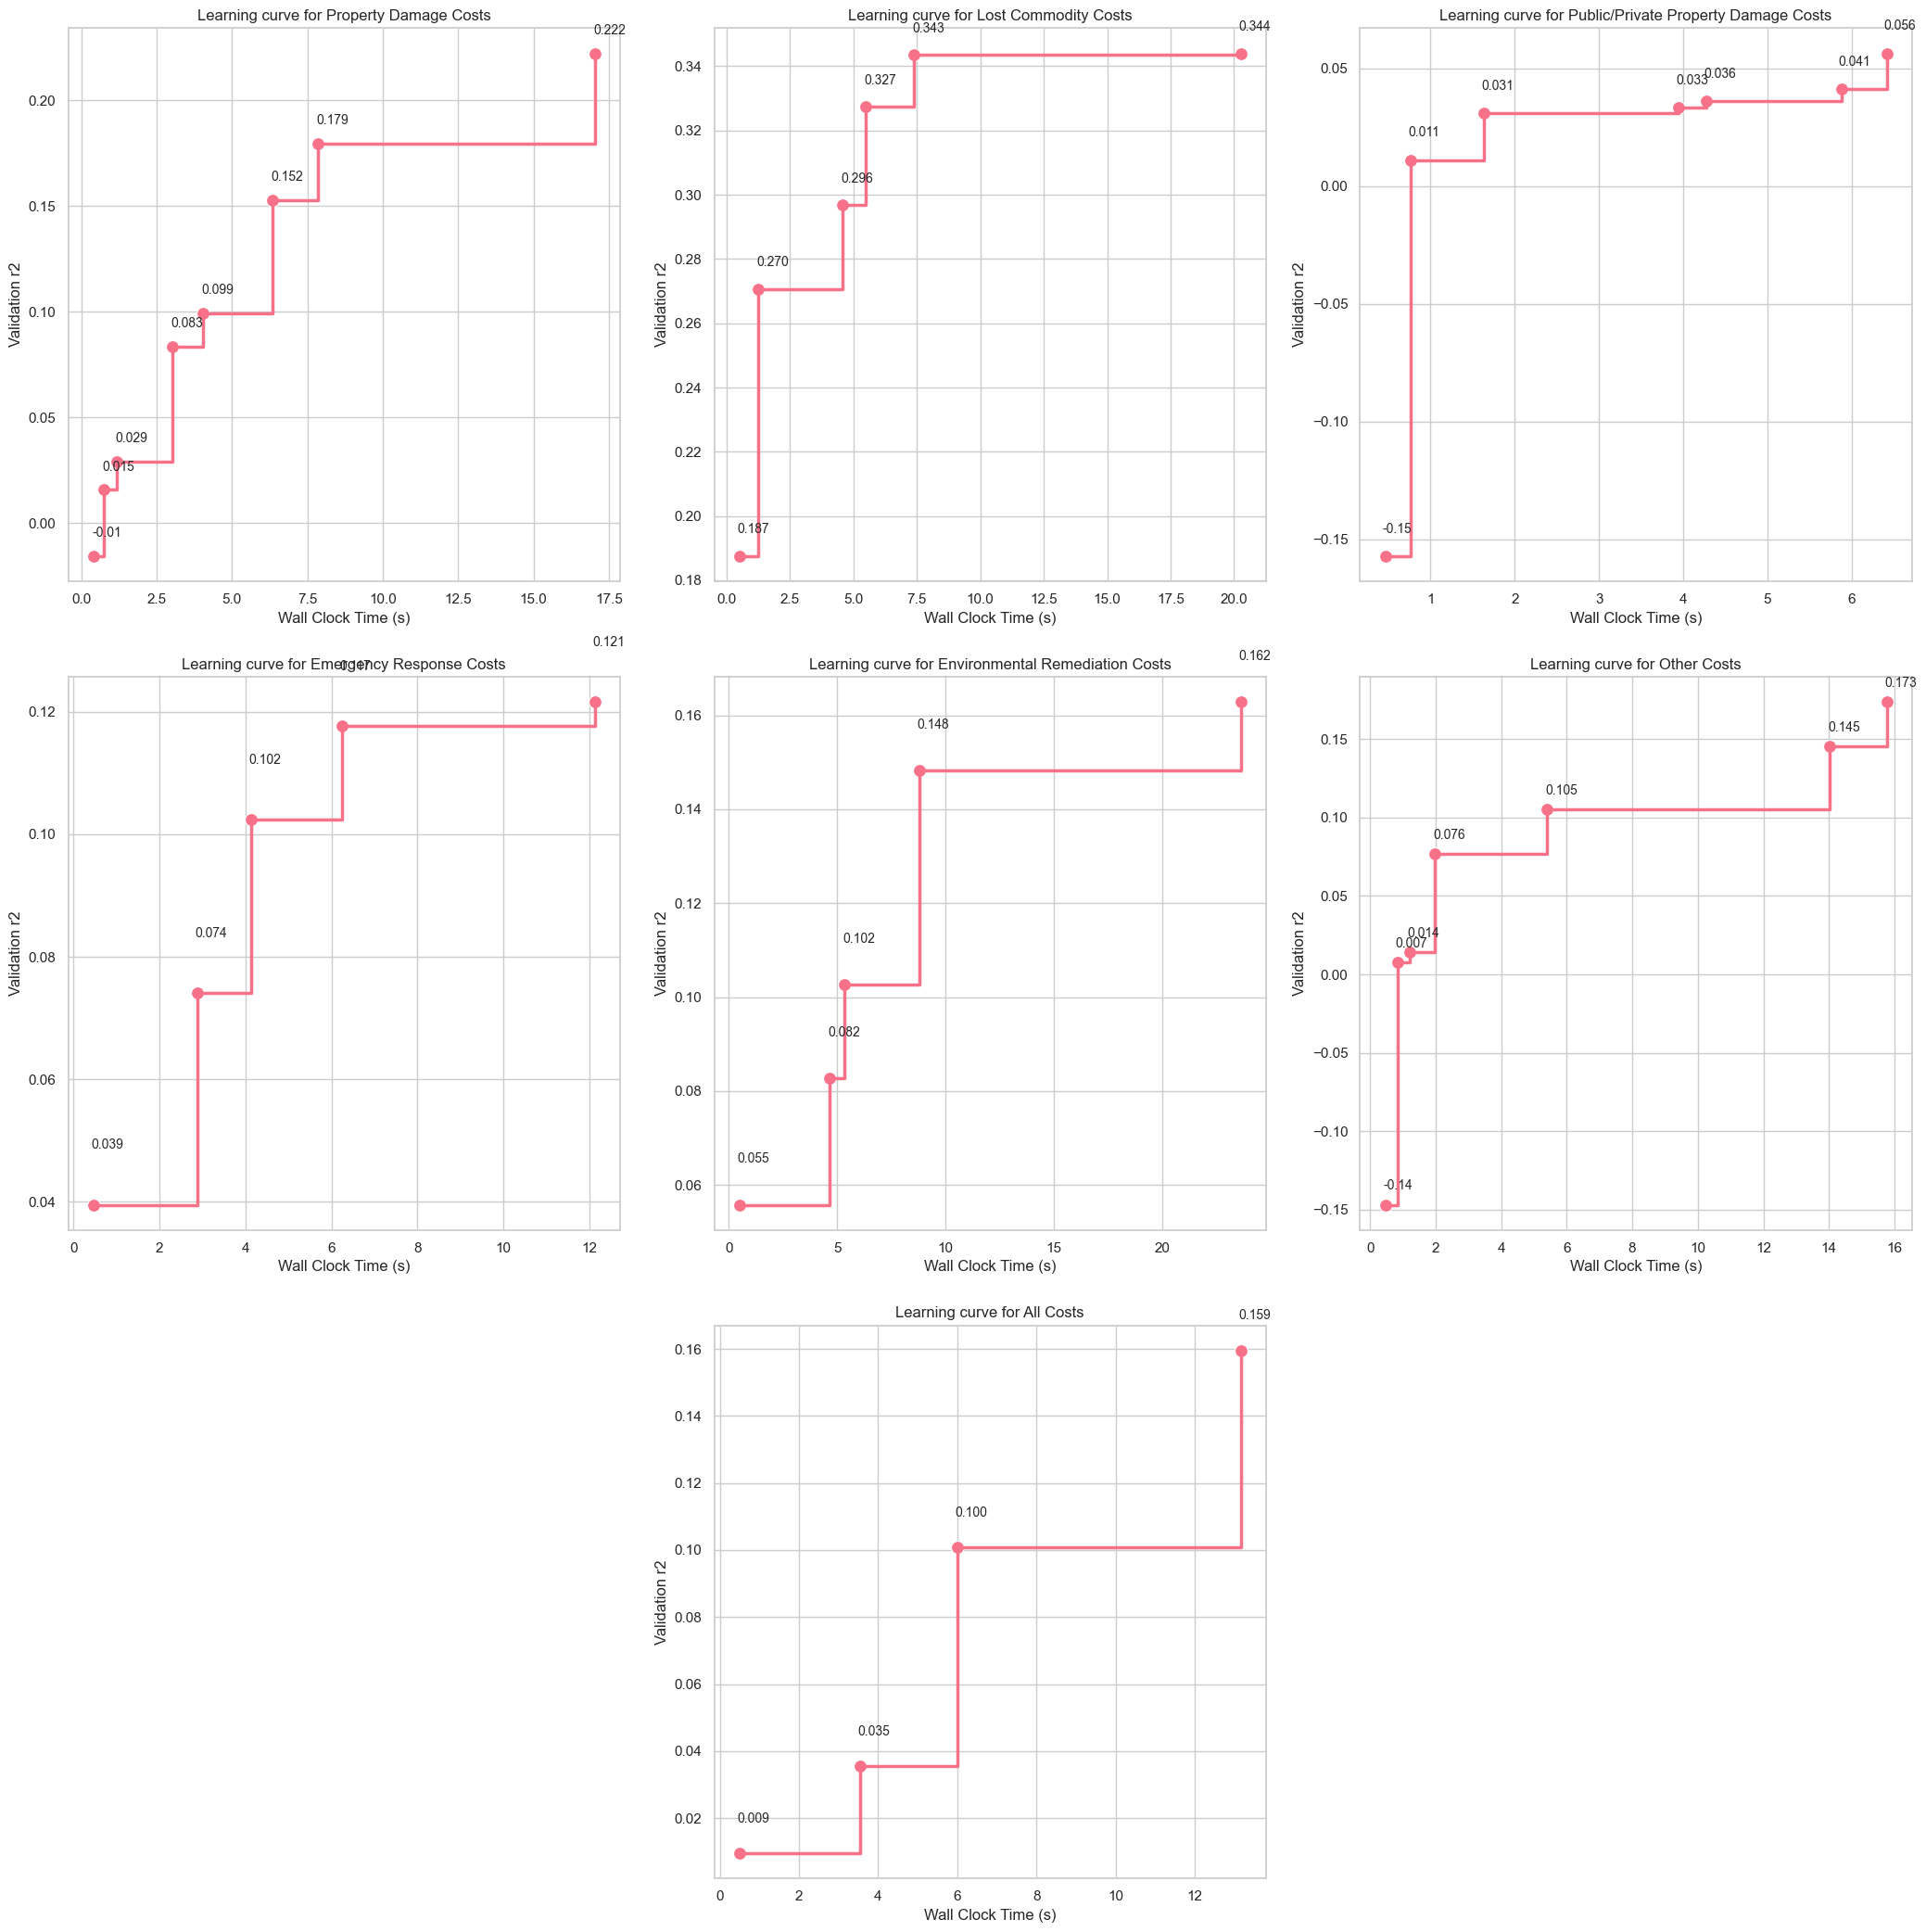

In [621]:
fig, axes = plot_learning(filenames, target)
plt.show()